In [37]:
from lib.datasets import Dataset2p0
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from lib.models import ResNet as MODEL

In [38]:
data_dir = 'data/w1_balanced_normalized'
trainloader = DataLoader(Dataset2p0(dir=f'{data_dir}/train/',labels=f'{data_dir}/y_train.pt'),batch_size=64,shuffle=True)
devloader = DataLoader(Dataset2p0(dir=f'{data_dir}/test/',labels=f'{data_dir}/y_test.pt'),batch_size=64,shuffle=True)

In [39]:
from torch import nn
model = MODEL().cuda()
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print(params)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-5)
device = 'cuda'

5699


In [40]:
loss_tr = []
loss_dev = []

for epoch in tqdm(range(10)):
    # train loop
    model.train()
    loss_tr_total = 0
    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr.view(-1,1,5000))
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_tr_total += loss.item()
    loss_tr.append(loss_tr_total/len(trainloader))

    # dev loop
    model.eval()
    loss_dev_total = 0
    for (X_dv,y_dv) in devloader:
        X_dv,y_dv = X_dv.to(device),y_dv.to(device)
        logits = model(X_dv.view(-1,1,5000))
        loss = criterion(logits,y_dv)
        loss_dev_total += loss.item()
    loss_dev.append(loss_dev_total/len(devloader))

100%|██████████| 5218/5218 [01:27<00:00, 59.90it/s]


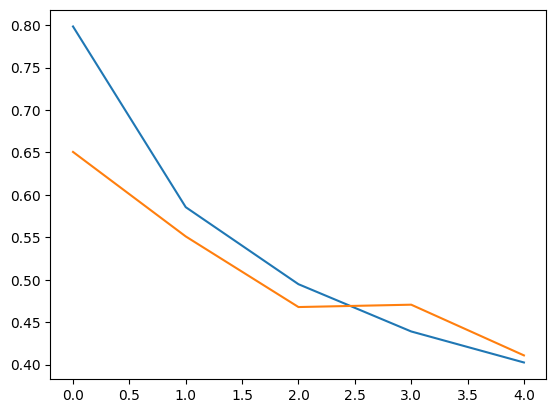

In [9]:
plt.plot(loss_tr)
plt.plot(loss_dev)

In [32]:
lossi = []

# train loop
model.train()
for (X_tr,y_tr) in tqdm(trainloader):
    X_tr,y_tr = X_tr.to(device),y_tr.to(device)
    logits = model(X_tr.view(-1,1,5000))
    loss = criterion(logits,y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())

100%|██████████| 5218/5218 [01:27<00:00, 59.92it/s]


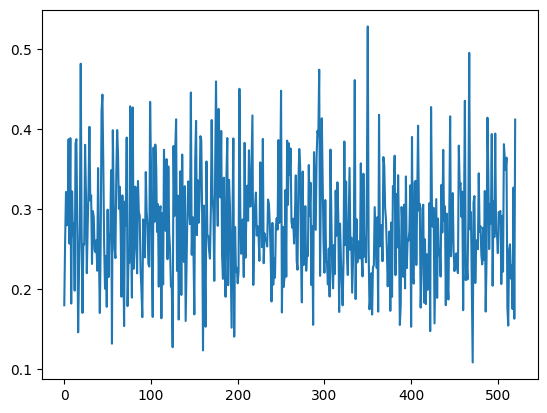

In [33]:
res = 10
plt.plot(torch.tensor(lossi[:len(lossi)-len(lossi)%res]).view(-1,res)[:,0])

In [35]:
torch.tensor(lossi).mean()

tensor(0.2805)

0.35573542340812925


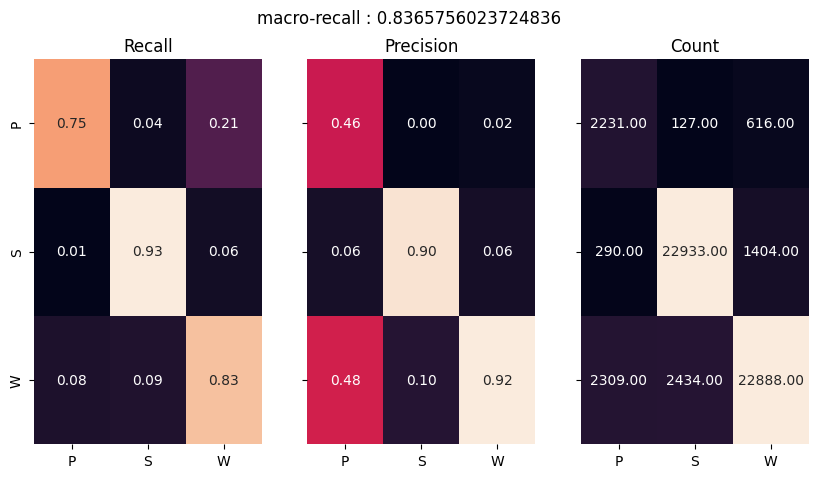

In [36]:
from lib.utils import cms
# test confusion matrices
# dev loop
y_true = torch.Tensor()
y_pred = torch.Tensor().cuda()
model.eval()
loss_dev_total = 0
for (X_dv,y_dv) in devloader:
    X_dv,y_dv = X_dv.to(device),y_dv.to(device)
    logits = model(X_dv)
    loss = criterion(logits,y_dv)
    loss_dev_total += loss.item()

    y_true = torch.cat([y_true,y_dv.cpu().argmax(axis=1)])
    y_pred = torch.cat([y_pred,torch.softmax(logits,dim=1).argmax(axis=1)])

print(loss_dev_total/len(devloader))
cms(y_true=y_true,y_pred=y_pred.cpu(),current_date=None)

In [ ]:
torch.save(model,'model.pt')